<a href="https://colab.research.google.com/github/Alexandre-Esposte/deteccao-de-terremoto-com-machine-learning-e-IoT/blob/main/terremoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest, probplot
from sklearn.model_selection import train_test_split, cross_val_score

# Modelos que serão utilizados para a classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Objetos para a padronização dos dados
from sklearn.preprocessing import StandardScaler


# Métricas para avaliar os modelos
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


Carregando a base de dados

In [ ]:
df = pd.read_csv('terremoto.csv')

Verificando a base

In [ ]:
df.head()

,aX,aY,aZ,gX,gY,gMZ,Result,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,-2176,996,-16868,-5168,3575,-2882,1,NaN,NaN,NaN,NaN
1,-2176,996,-16868,-5168,3575,-2882,1,NaN,NaN,NaN,NaN
2,-6564,-1340,-13532,-5136,-8924,3258,1,NaN,NaN,NaN,NaN
3,-8,2316,-23504,-5168,5999,11,1,NaN,NaN,NaN,NaN
4,17064,-5608,10432,-5152,-4301,1899,1,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59276 entries, 0 to 59275
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aX           59276 non-null  int64  
 1   aY           59276 non-null  int64  
 2   aZ           59276 non-null  int64  
 3   gX           59276 non-null  int64  
 4   gY           59276 non-null  int64  
 5   gMZ          59276 non-null  int64  
 6   Result       59276 non-null  int64  
 7   Unnamed: 7   0 non-null      float64
 8   Unnamed: 8   0 non-null      float64
 9   Unnamed: 9   0 non-null      float64
 10  Unnamed: 10  1 non-null      object 
dtypes: float64(3), int64(7), object(1)
memory usage: 5.0+ MB


Existem algumas colunas que não contém nenhum tipo de informação e por isso serão removidas da análise

In [ ]:
df = df[['aX','aY','aZ','gX','gY','gMZ','Result']]

In [ ]:
df.head()

,aX,aY,aZ,gX,gY,gMZ,Result
0,-2176,996,-16868,-5168,3575,-2882,1
1,-2176,996,-16868,-5168,3575,-2882,1
2,-6564,-1340,-13532,-5136,-8924,3258,1
3,-8,2316,-23504,-5168,5999,11,1
4,17064,-5608,10432,-5152,-4301,1899,1


Verificando se há valores duplicados e faltantes

In [ ]:
print(f'Duplicados: {df.duplicated().sum()}\n\nValores faltantes:\n{df.isna().sum()}')

Duplicados: 4

Valores faltantes:
aX        0
aY        0
aZ        0
gX        0
gY        0
gMZ       0
Result    0
dtype: int64


Removendo os valores duplicados

In [ ]:
df.drop_duplicates(inplace=True)
print(f'Duplicados: {df.duplicated().sum()}\n\nValores faltantes:\n{df.isna().sum()}')

Duplicados: 0

Valores faltantes:
aX        0
aY        0
aZ        0
gX        0
gY        0
gMZ       0
Result    0
dtype: int64


Observaremos agora algumas informações da base

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59272 entries, 0 to 59275
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   aX      59272 non-null  int64
 1   aY      59272 non-null  int64
 2   aZ      59272 non-null  int64
 3   gX      59272 non-null  int64
 4   gY      59272 non-null  int64
 5   gMZ     59272 non-null  int64
 6   Result  59272 non-null  int64
dtypes: int64(7)
memory usage: 3.6 MB


Há 59272 linhas sendo todas as colunas e linhas do tipo inteiro.

Agora iremos alterar o nome das colunas para uma maior comodidade

In [ ]:
df.rename(columns = {'aX':'ax','aY':'ay','aZ':'az','gX':'gx','gY':'gy','gMZ':'gz','Result':'res'},inplace=True)

In [ ]:
df.head()

,ax,ay,az,gx,gy,gz,res
0,-2176,996,-16868,-5168,3575,-2882,1
2,-6564,-1340,-13532,-5136,-8924,3258,1
3,-8,2316,-23504,-5168,5999,11,1
4,17064,-5608,10432,-5152,-4301,1899,1
5,-1036,-5332,-7712,-5136,7595,-3474,1


Agora vamos visualizar algumas estatísticas da base

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ax,59272.0,95.721622,9595.337361,-32768.0,-1180.0,-656.0,1500.0,32767.0
ay,59272.0,-1166.021089,5704.718570,-32768.0,-1520.0,-1372.0,-756.0,32767.0
az,59272.0,-14675.885005,14835.582082,-32768.0,-17853.0,-17200.0,-16316.0,32767.0
gx,59272.0,-3510.452187,399.249070,-5200.0,-3760.0,-3488.0,-3328.0,-1.0
gy,59272.0,34.954852,4192.777799,-32768.0,-82.0,61.0,102.0,32767.0
gz,59272.0,311.857302,4514.260357,-32768.0,220.0,269.0,376.0,32767.0
res,59272.0,0.516163,0.499743,0.0,0.0,1.0,1.0,1.0


Análise univariada para cada feature

Contagem de classes: 
1    30594
0    28678
Name: res, dtype: int64

Proporção das classes:
1    0.516163
0    0.483837
Name: res, dtype: float64


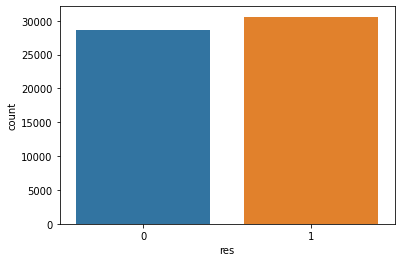

In [ ]:
print(f"Contagem de classes: \n{df['res'].value_counts(normalize=False)}\n\nProporção das classes:\n{df['res'].value_counts(normalize=True)}")
sns.countplot(data = df , x='res');

O banco apresenta um "leve" desbalanceamento com relação as duas classes da coluna res

Abaixo o histograma de cada feature com sua respectiva ecdf.

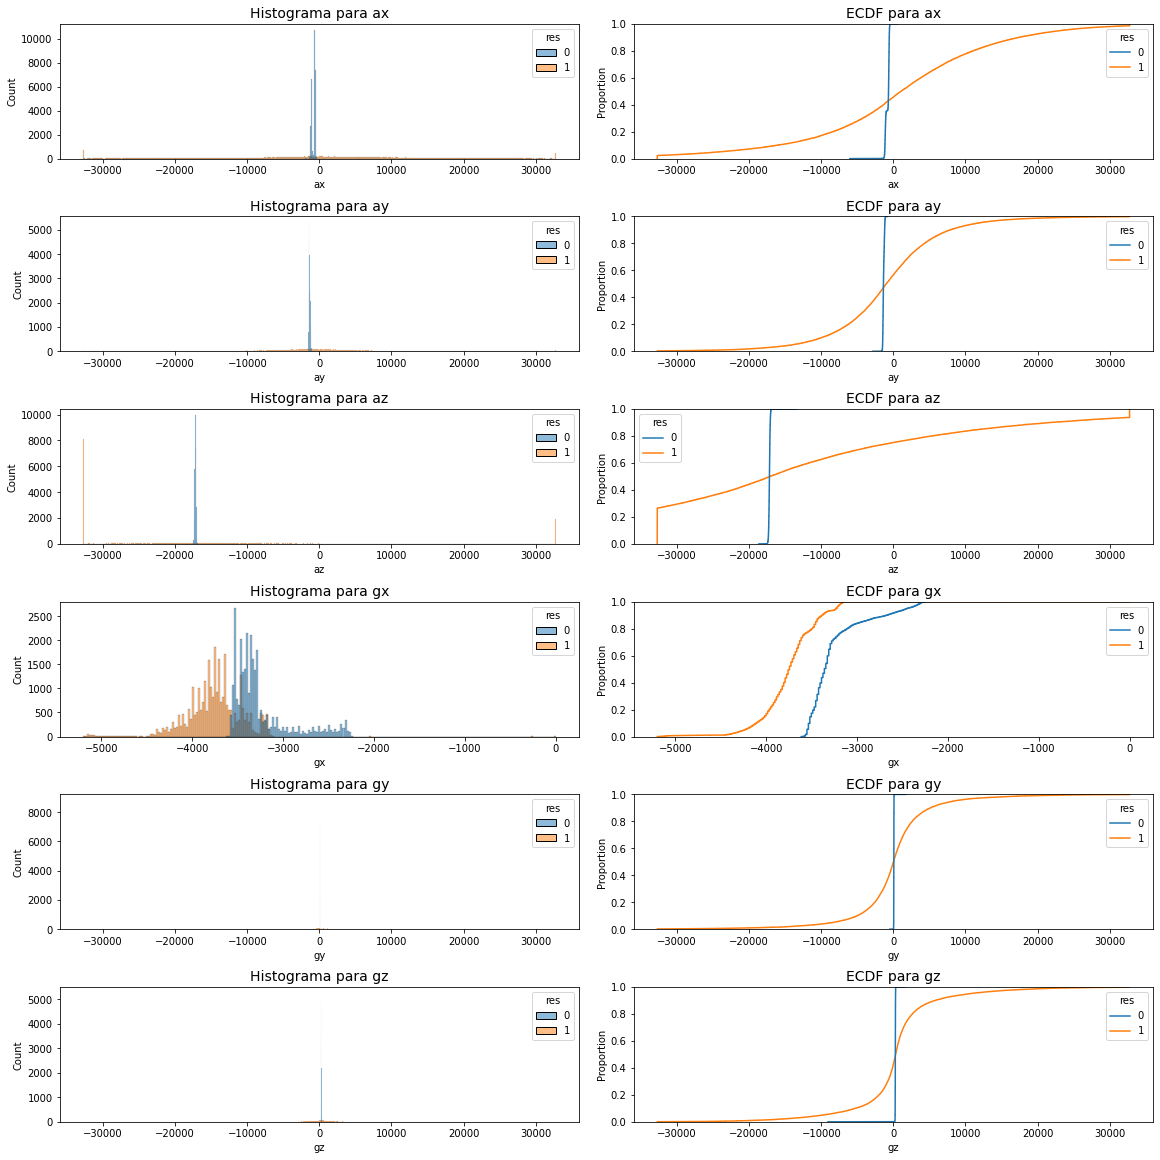

In [ ]:
fig , ax = plt.subplots(6,2,constrained_layout = True, figsize=(16,16))

row = 0
for i in df.columns:
  if i != 'res':
    
    sns.histplot(data = df, x = i, ax = ax[row][0],hue='res')
    sns.ecdfplot(data = df, x = i, ax = ax[row][1],hue='res')
    ax[row][0].set_title(f'Histograma para {i}',fontsize=14)
    ax[row][1].set_title(f'ECDF para {i}',fontsize=14)
  row+=1
    
fig.savefig('figura.png',format='png',quality = 100)

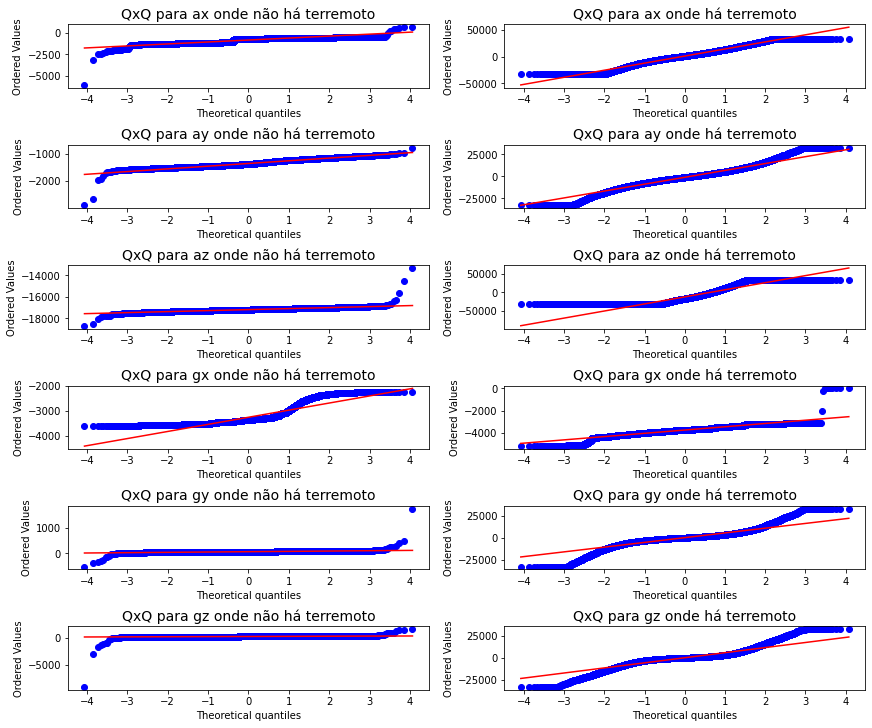

In [ ]:
fig , ax = plt.subplots(6,2,constrained_layout = True, figsize=(12,10),sharey=False)

row = 0
for i in df.columns:
  if i != 'res':
    
    res1 = probplot(df.query('res == 0')[i], plot=ax[row][0],dist='norm')
    res2 = probplot(df.query('res == 1')[i], plot=ax[row][1],dist='norm')
    ax[row][0].set_title(f'QxQ para {i} onde não há terremoto',fontsize=14)
    ax[row][1].set_title(f'QxQ para {i} onde há terremoto',fontsize=14)
  row+=1
    
fig.savefig('figura.png',format='png',quality = 100,dpi=1250)

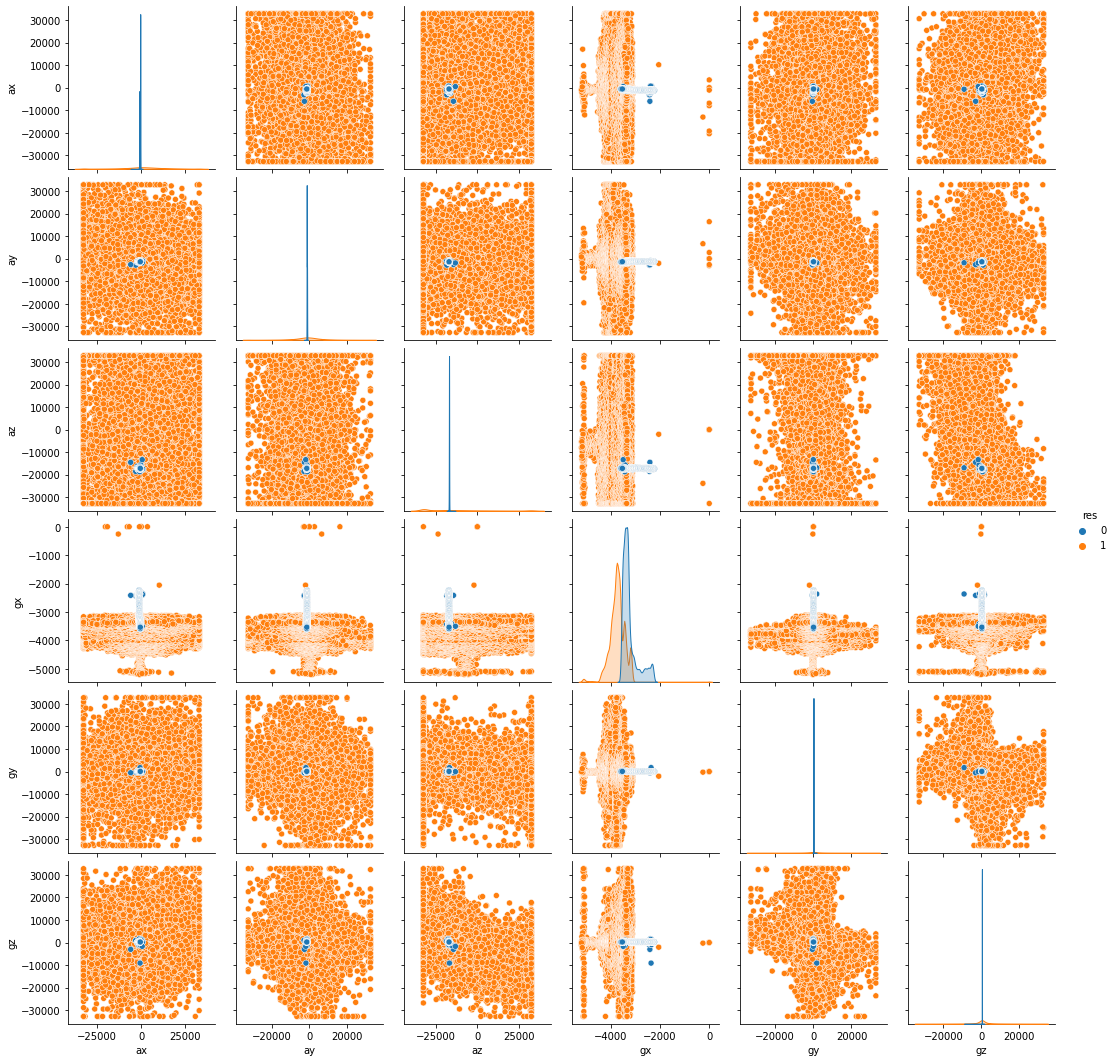

In [ ]:
#plt.figure(figsize=(30,16))
sns.pairplot(data = df,hue='res');
plt.savefig('figura.png',format='png')

2° Etapa - Construção do modelo preditivo

Separando o conjunto de treino e teste

In [ ]:
# Separando as features da váriavel resposta ou dependente

X = df.drop(columns='res')
y = df['res']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Análisando o conjunto y_train

In [ ]:
print(f'Contagem:\n{y_train.value_counts(normalize = False)}\n\nFrequências relativas:\n{y_train.value_counts(normalize = True)}')

Contagem:
1    24488
0    22929
Name: res, dtype: int64

Frequências relativas:
1    0.516439
0    0.483561
Name: res, dtype: float64


Vamos utilizar um dummyClassifier para servir de referência para os demais modelos

In [ ]:
modelos = {}

modelos['regressao logistica'] = LogisticRegression()
modelos['arvore'] = DecisionTreeClassifier()
modelos['floresta'] = RandomForestClassifier()
modelos['svm'] = SVC()
modelos['knn'] = KNeighborsClassifier()
modelos['naive'] = GaussianNB()
modelos['referencia'] = DummyClassifier(strategy = 'most_frequent')

In [ ]:
resultados_treino = {}
for clf in list(zip(modelos.keys(),modelos.values())):
  cv_results = cross_val_score(clf[1], X_train, y_train, cv= 5, scoring='accuracy')
  resultados_treino[clf[0]] = cv_results 
  print(f'Modelo: {clf[0]}')

Modelo: regressao logistica
Modelo: arvore
Modelo: floresta
Modelo: svm
Modelo: knn
Modelo: naive
Modelo: referencia


In [ ]:
resultados_treino

{'regressao logistica': array([0.41501476, 0.40763391, 0.4133713 , 0.41231678, 0.40345882]),
 'arvore': array([0.99957824, 0.99978912, 0.99968364, 0.99915639, 0.99957819]),
 'floresta': array([0.9994728 , 0.99989456, 0.99968364, 0.99957819, 0.99989455]),
 'svm': array([0.99167018, 0.99283003, 0.99240747, 0.99114204, 0.99209111]),
 'knn': array([0.99926191, 1.        , 0.9997891 , 0.99947274, 0.99947274]),
 'naive': array([0.99894559, 0.9994728 , 0.99968364, 0.99894548, 0.99926184]),
 'referencia': array([0.51644876, 0.51644876, 0.51639776, 0.51639776, 0.51650322])}

In [ ]:
resultado_treino_df = pd.DataFrame(resultados_treino)

In [ ]:
resultado_treino_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regressao logistica,5.0,0.410359,0.004733,0.403459,0.407634,0.412317,0.413371,0.415015
arvore,5.0,0.999557,0.000240,0.999156,0.999578,0.999578,0.999684,0.999789
floresta,5.0,0.999705,0.000189,0.999473,0.999578,0.999684,0.999895,0.999895
svm,5.0,0.992028,0.000653,0.991142,0.991670,0.992091,0.992407,0.992830
knn,5.0,0.999599,0.000293,0.999262,0.999473,0.999473,0.999789,1.000000
naive,5.0,0.999262,0.000325,0.998945,0.998946,0.999262,0.999473,0.999684
referencia,5.0,0.516439,0.000044,0.516398,0.516398,0.516449,0.516449,0.516503


Treinando os modelos com todo o conjunto de treino e realizando a validação

In [ ]:
modelos

{'regressao logistica': LogisticRegression(),
 'arvore': DecisionTreeClassifier(),
 'floresta': RandomForestClassifier(),
 'svm': SVC(),
 'knn': KNeighborsClassifier(),
 'naive': GaussianNB(),
 'referencia': DummyClassifier(strategy='most_frequent')}

In [ ]:
preditos = {}

acc_treino= []
acc_test = []

recall_treino= []
recall_test = []

precision_treino= []
precision_test = []

f1_treino= []
f1_test = []


for clf in list(zip(modelos.keys(),modelos.values())):
  clf[1].fit(X_train,y_train)

  pred_train = clf[1].predict(X_train) 

  pred_test = clf[1].predict(X_test)

  acc_treino.append(accuracy_score(y_train,pred_train))
  acc_test.append(accuracy_score(y_test,pred_test))

  recall_treino.append(recall_score(y_train,pred_train))
  recall_test.append(recall_score(y_test,pred_test))

  precision_treino.append(precision_score(y_train,pred_train))
  precision_test.append(precision_score(y_test,pred_test))

  f1_treino.append(f1_score(y_train,pred_train))
  f1_test.append(f1_score(y_test,pred_test))

  preditos[clf[0]] = pred_test

  print(f'Modelo: {clf[0]}')


Modelo: regressao logistica
Modelo: arvore
Modelo: floresta
Modelo: svm
Modelo: knn
Modelo: naive
Modelo: referencia


In [ ]:
resultados = {"acc treino":acc_treino, "acc teste": acc_test,"recall treino":recall_treino, "recall teste": recall_test,
              "precision treino":precision_treino, "precision teste": precision_test,"f1 treino":f1_treino, "f1 teste": f1_test}

pd.DataFrame(resultados,index=modelos.keys())

,acc treino,acc teste,recall treino,recall teste,precision treino,precision teste,f1 treino,f1 teste
regressao logistica,0.410570,0.409532,0.633249,0.632984,0.449804,0.448168,0.525991,0.524779
arvore,1.000000,0.999410,1.000000,0.999509,1.000000,0.999345,1.000000,0.999427
floresta,1.000000,0.999494,1.000000,0.999836,1.000000,0.999182,1.000000,0.999509
svm,0.992914,0.991733,0.986361,0.984114,0.999917,0.999834,0.993093,0.991912
knn,0.999705,0.999578,0.999592,0.999509,0.999837,0.999672,0.999714,0.999591
naive,0.999304,0.999325,0.999796,0.999672,0.998858,0.999018,0.999327,0.999345
referencia,0.516439,0.515057,1.000000,1.000000,0.516439,0.515057,0.681121,0.679918
